# Perceptrón

En esta libreta se implementa un clasificador binario con el algoritmo del perceptrón.

### Bibliotecas externas

Se hace uso de [Gadfly](http://gadflyjl.org/) para graficar los datos y de [RDatasets](https://github.com/johnmyleswhite/RDatasets.jl) para importar el conjunto de datos Iris, el cuál se usará para trabajar con el perceptrón.

In [1]:
using Gadfly
using RDatasets

### Los datos de entrenamiento

El algoritmo del perceptrón, en su forma más simple, requiere trabajar sobre datos *linealmente separables* para poder terminal su entrenamiento.

Podemos graficar los datos de entrenamiento para verificar visualmente que son linealmente separables.

En la gráfica de abajo se observa que las **setosas** son linealmente separables del resto de las clases.

In [2]:
iris = dataset("datasets", "iris");

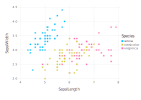

In [3]:
plot(iris, x=:SepalLength, y=:SepalWidth, color=:Species, Geom.point)

Se obtienen las columnas de atributos que nos son de interés y luego se transforman las clases de cadenas de caracteres a los valores numéricos $\{-1,1\}$.

In [4]:
sepalLength = iris[:SepalLength];
sepalWidth = iris[:SepalWidth];
species = iris[:Species];

inputs = [sepalLength sepalWidth];
outcomes = map(name -> name == "setosa" ? +1 : -1, species);

### Predicción

El perceptrón es un clasificador binario lineal, se parametriza con $d+1$ valores reales, donde $d$ es la dimensión de cada dato de entrada.

La predicción del perceptrón se define como:

$$\mathrm{p}(\hat{x})=\mathrm{sign}( \hat{w}^{T} \cdot \hat{x} + b)$$

Donde $\hat{x}$ es el vector de entradas, $\hat{w}$ y $b$ son los parámetros del perceptrón, tal que $\|\hat{x}\|=\|\hat{w}\|$.

In [5]:
function predict(weights, bias, input)
    return sign(weights' * input + bias)
end

predict (generic function with 1 method)

### Entrenamiento

Para el entrenamiento, se inicia con todos los parámetros en $0.0$ y se mejoran a partir de los datos mal clasificados, hasta haber conseguido clasificar correctamente todos los datos.

In [6]:
function train(inputs, outcomes)
    measures, dimensions = size(inputs);
    
    weights = zeros(dimensions);
    bias = 0.0
    
    while true
        badResults = 0
        for i in 1:measures
            if predict(weights, bias, inputs[i,:]) != outcomes[i]
                badResults += 1
                weights += outcomes[i] * inputs[i,:]
                bias += outcomes[i]
            end
        end
        badResults == 0 && break
    end
    
    return weights, bias
end

train (generic function with 1 method)

Con el entrenamiento se obtienen los parámetros que separan los datos de entrenamiento.

Estos parámetros, para el caso de $d=2$ pueden ser usados para describir el clasificador como una recta.

In [7]:
weights, bias = train(inputs, outcomes);

slope = -weights[1]/weights[2]
x2cut = -bias/weights[2]
cutsign = x2cut < 0 ? "-" : "+"

println("weights: ", weights)
println("bias: ", bias)
println("classifier line: x2 = $(slope)*x1$(cutsign)$(abs(x2cut))")

weights: [-79.8, 101.4]
bias: 126.0
classifier line: x2 = 0.7869822485207414*x1-1.2426035502958825


Como se observa en la gráfica de abajo, el entrenamiento ha funcionado.

In [8]:
function weightsToLine(bias, weights)
    return (length) -> -(bias+weights[1]*length)/weights[2]
end

weightsToLine (generic function with 1 method)

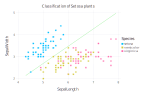

In [9]:
plot(
    layer(
        iris, x=:SepalLength, y=:SepalWidth, color=:Species,
        Geom.point
    ),
    layer(
        weightsToLine(bias, weights),
        minimum(iris[:SepalLength]),
        maximum(iris[:SepalLength]),
        Theme(default_color=colorant"light green")
    ),
    Guide.Title("Classification of Setosa plants")
)

### ¿Por qué funciona?

---

#### Nota
De esta sección en adelante consideramos a los vectores de entrada $\bar{x}=[1, \hat{x}_1, ..., \hat{x}_d]$ y al vector de parámetros $\bar{w}=[b, \hat{w}_1, ..., \hat{w}_d]$. De tal manera que:
$$\mathrm{p}(\hat{x})=\mathrm{sign}(\hat{w}^{T} \cdot \hat{x} + b) = \mathrm{sign}(\bar{w}^T \cdot \bar{x}) = \mathrm{p}(\bar{x})$$
Adicionalmente se denota como $\mathrm{p}(\bar{x}; \bar{w})$ a la predicción de la entrada $\bar{x}$ considerando los parámetros $\bar{w}$ y también se usa la notación $\bar{x}(t)$, $y(t)$ y $\bar{w}(t)$ para referirse a una entrada, clase o parámetros de una iteración $t$ del algoritmo de aprendizaje.

---

El algoritmo del perceptrón funciona ya que se suponen dos restricciones muy fuertes sobre los datos de entrenamiento:

1. Los datos están acotados
2. Los datos son linealmente separables

#### Suposición 1: Los datos están acotados
El primer punto se refiere a que las normas o magnitudes de los vectores de entrada $\|\bar{x}\|$ son finitas. En particular, suponemos que existe un máximo finito para las normas de los datos de entrada de tal manera que existe $R \in \mathbb{R}$ tal que $\|\bar{x}\| \leq R$ para todo $\bar{x}$ en el conjunto de entrenamiento.

Otra manera de verbalizar este punto es "tus datos de entrada se tienen que conformar de números concretos y tienes que usar una cantidad concreta de datos de entrada, nada de infinitos". Quizá esta suposición parezca algo obvia, pero hay que recordar que se pudieran plantear datos de entrenamiento definidos a partir de una función no acotada. Por ejemplo, si intentamos entrenar a un perceptrón con datos de entrenamiento definidos por dos rectas paralelas (donde los valores de la primera recta representan a las entradas pertenecientes a la clase $+1$ y los valores de la segunda a las entradas pertenecientes a la clase $-1$) como se muestra en la gráfica de abajo, es fácil ver como el perceptrón se la puede rifar. 

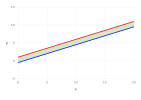

In [10]:
xs = collect(0:20)
ys1 = .5 * xs + 1
ys2 = .5 * xs - .5

plot(
    layer(x=xs, y=ys1, Geom.line, Theme(default_color=colorant"red", line_width=2pt)),
    layer(x=xs, y=ys2, Geom.line, Theme(default_color=colorant"blue", line_width=2pt)),
    layer(x=xs, ymin=ys1, ymax=ys2, Geom.ribbon, Theme(default_color=colorant"light green"))
)

El perceptrón va a entrenarse hasta llegar a unos parámetros cuya recta asociada se encuentra en la parte verde. Sin embargo, en el caso general, definir datos de entrada de esta manera no nos permitirá establecer que el algoritmo va a terminar de aprender en una cantidad finita de pasos.

Si las funciones que describen los puntos se pueden separar con una recta como en el ejemplo anterior. ¿Es posible demostrar que el algoritmo converge cuando la cantidad de iteraciones tiende al infinito?

Yo creo que si, pero la neta no sé. Un ejemplo concreto es el siguiente, en donde las áreas sombreadas determinan los puntos clasificados:

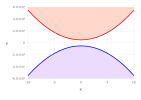

In [11]:
xs = collect(-10:10)
ys1 = 50 * xs .* xs + 500
ys2 = -(50 .* xs .* xs + 500)

plot(
    layer(x=xs, y=ys1, Geom.smooth, Theme(default_color=colorant"red", line_width=2pt)),
    layer(x=xs, ymin=ys1, ymax=zeros(xs)+6000, Geom.ribbon, Theme(default_color=colorant"red")),
    layer(x=xs, y=ys2, Geom.smooth, Theme(default_color=colorant"blue", line_width=2pt)),
    layer(x=xs, ymin=ys2, ymax=zeros(xs)-6000, Geom.ribbon, Theme(default_color=colorant"blue"))
)

#### Suposición 2: Los datos son linealmente separables
El segundo punto se refiere a que dado un conjunto de entrenamiento, existe al menos un vector $\bar{w}^*$ el cuál separa todos los datos de entrenamiento de manera perfecta. En particular, suponemos que existe un márgen finito $\gamma > 0$ tal que:

$$y(t)\cdot \bar{w}^{*T}(t)\cdot \bar{x}(t) \geq \gamma$$

La anterior desigualdad puede ser difícil de parsear a primera vista, para comprender a qué se refiere hay que recordar que $\bar{w}^*$ clasifica de manera *perfecta* los datos de entrenamiento. Ya que $\bar{w}^{*T}\cdot \bar{x}$ tiene el mismo signo que $y$, la multiplicación $y\cdot \bar{w}^{*T}\cdot \bar{x}$ será siempre positiva ("mas por mas es mas, menos por menos es mas"). Entre más lejano esté la entrada $\bar{x}$ de la recta descrita por $\bar{w}$, más grande será su producto, siendo el producto $0$ cuando la entrada se encuentra exactamente sobre la recta (en cuyo caso, el algoritmo de entrenamiento lo considera como una entrada mal clasificada).

Para ilustrar esto, consideremos unos datos ya clasificados y un perceptrón ya entrenado cuya representación en recta es la siguiente:

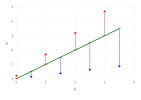

In [12]:
xs1 = [0, 1, 2, 3]
xs2 = [.5, 1.5, 2.5, 3.5]
ys1 = 1.5 * xs1 + .2
ys2 = .25 * xs2
x = [xs1; xs2]
y = x
plot(
    layer(x=xs1, y=ys1, Geom.point, Theme(default_color=colorant"red", point_size=3pt)),
    layer(x=xs1, ymin=xs1, ymax=ys1, Geom.errorbar, Theme(default_color=colorant"red")),
    layer(x=xs2, y=ys2, Geom.point, Theme(default_color=colorant"blue", point_size=3pt)),
    layer(x=xs2, ymin=xs2, ymax=ys2, Geom.errorbar, Theme(default_color=colorant"blue")),
    layer(x=x, y=y, Geom.line, Theme(default_color=colorant"green", line_width=2pt))
)

Las líneas que van de cada entrada a la recta verde representan su margen. La longitud de cada una de estas rectas es:

In [13]:
println("para las entradas clasificadas como +1 (rojas): ", ys1 - xs1)
println("para las entradas clasificadas como -1 (azules): ", xs2 - ys2)

para las entradas clasificadas como +1 (rojas): [0.2, 0.7, 1.2, 1.7]
para las entradas clasificadas como -1 (azules): [0.375, 1.125, 1.875, 2.625]


Mientras que el el resultado del producto interno de los parámetros con cada dato de entrenamiento es:

In [14]:
println("para las entradas clasificadas como +1 (rojas): ", hcat(ones(xs1), xs1, ys1) * [0, 1, 1])
println("para las entradas clasificadas como -1 (azules): ", hcat(ones(xs2), xs2, ys2) * [0, 1, 1])

para las entradas clasificadas como +1 (rojas): [0.2, 2.7, 5.2, 7.7]
para las entradas clasificadas como -1 (azules): [0.625, 1.875, 3.125, 4.375]


A pesar de ser diferentes, cuando uno crece, el otro también.

El punto central de esta ilustración es que el márgen $\gamma$ puede corresponder a cualquier valor entre $0$ y el márgen más pequeño de los datos de entrenamiento. En este ejemplo, existe $\gamma$ ya que el dato más cercano a la recta tiene un márgen de $0.2$.

Esta suposición también pudiera ser considerada obvia, sin embargo no lo es del todo. Si al momento de calcular la predicción del perceptrón, hubiéramos escrito:

```julia
function predict(weights, bias, input)
    if weights' * input + bias >= 0
        return +1
    else
        return -1
    end
end
```

Estaríamos considerando que se puede clasificar correctamente un dato de entrada posicionado justo en la recta asociada a los parámetros, lo cuál hace posible encontrar parámetros cuyo márgen $\gamma$ pueda ser $0$. Esto no significa que el algoritmo no vaya a funcionar (en práctica si funciona), lo que sí significa es que la suposición que estamos realizando no es correcta y para fines de esta exploración, no nos sirve una función de predicción definida de la manera mencionada.

#### Tercera suposición escondida: Inicialización del perceptrón

Para este desarrollo se considera que el perceptrón siempre inicia su entrenamiento con parámetros $\bar{0}$. Esto con el afán de no añadir complejidad a la exploración mediante inicializaciones aleatorias.

### Finitud y finura del perceptrón

Utilizando las tres suposiciones presentadas y lo que conocemos del algoritmo del perceptrón, podemos demostrar que converge en una cantidad finita de pasos. Pero primero, es importante tener el *feeling* de que lo que hace el programa está "bien".

#### ¿Qué transa con la regla de actualización de parámetros?

Ignorando el hecho de que iteramos sobre un conjunto de entradas con sus respectivas salidas ("la clasificación correcta"), e ignorando el hecho de que usamos un criterio para detener el aprendizaje, nos quedamos únicamente con la *regla de actualización de parámetros* la cuál solo aplica a datos mal clasificados y se define como:

$$\bar{w}(t+1)=\bar{w}(t) + y(t)\cdot \bar{x}(t)$$

El primer paso para entender el funcionamiento del perceptrón es entender como mejora a lo largo de las iteraciones. Supongamos que estamos en una iteración $t$ donde el perceptrón clasifica de manera incorrecta una entrada. Es decir:

$$\mathrm{sign}(\bar{w}^T(t) \cdot \bar{x}(t)) \neq y(t)$$

¿Cómo mejora el perceptrón al calcular $\bar{w}(t+1)$?

Ya que $\bar{x}(t)$ es malclasificado, podemos calcular una idea de qué tan mal clasificado está calculando el producto $\bar{w}^T(t) \cdot \bar{x}(t)$. [explicado en suposición 2]

De tal manera que entre más cercano sea ese resultado a $0$, más cerca estamos de clasificarlo correctamente. Sin embargo, calcular este producto puede resultar en valores negativos o positivos (dependiendo de si se malclasificó como $+1$ o $-1$). Es por esto que es conveniente hacer uso de otra expresión para referirnos a que tan mala es la clasificación. Ya que el signo de $y(t)$ nunca va a coincidir con el signo del producto en cuestión (ya que estamos considerando una $\bar{x}(t)$ mal clasificada) y además $\mathrm{abs}(y)$ siempre es $1$ el siguiente producto siempre será menor a $0$:

$$y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)$$

En donde entre más cercano al $0$ sea el resultado, más cerca está el perceptrón de clasificar correctamente la entrada.

Para evitar saltos grandes en la lógica de la explicación, aquí están los casos que se pueden presentar:

- Si $\bar{x}(t)$ es clasificado incorrectamente por el perceptrón como $+1$, entonces $y(t)$ debe ser $-1$. Ya que $\bar{w}^T(t) \cdot \bar{x}(t)$ es mayor a $0$ (porque la predicción fué $+1$) y este nos da una idea de que tan mal clasificado está, tenemos que:
$$y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t) = -1 \cdot (\bar{w}^T(t) \cdot \bar{x}(t)) < 0$$
- Si $\bar{x}(t)$ es clasificado incorrectamente por el perceptrón como $-1$, entonces $y(t)$ debe ser $+1$. Ya que $\bar{w}^T(t) \cdot \bar{x}(t)$ es menor a $0$ (porque la predicción fué $-1$) y este nos da una idea de que tan mal clasificado está, tenemos que:
$$y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t) = +1 \cdot (\bar{w}^T(t) \cdot \bar{x}(t)) < 0$$

Teniendo este criterio representando "que tan chafa predice el perceptrón" y conciderando que entre más gránde sea este criterio mejor, podemos determinar que la regla de actualización hace que los parámetros se muevan en la dirección correcta.

Antes de desarrollar matemáticamente este planteamiento, es conveniente visualizar cómo cambia la recta asociada a los parámetros al aplicar la regla de actualización. Consideremos un perceptrón con parámetros $[0.5, -5, 2]$ y un dato mal clasificado $[5, 5]$

In [15]:
ws = [5, -50, 20]
line = weightsToLine(ws[1], ws[2:end])
x = [1, 0.25, 0.25]
y = +1
err = ws' * x

-2.5

El dato debería de estar por encima de la recta (ya que su clase es $+1$), sin embargo, los parámetros actuales lo clasifican de manera negativa (el dato se encuentra por debajo de la recta):

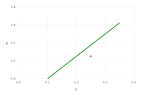

In [16]:
plot(
    layer(line, 0.1, 0.35, Theme(default_color=colorant"green", line_width=2pt)),
    layer(x=[x[2]], y=[x[3]], Geom.point, Theme(default_color=colorant"red"))
)

Al aplicar la regla de actualización, la recta asociada a los parámetros del perceptrón se acerca más a clasificar el dato de manera correcta:

In [17]:
nextWs = ws + y * x
nextLine = weightsToLine(nextWs[1], nextWs[2:end])
nextErr = nextWs' * x

-1.375

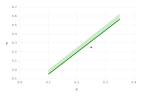

In [18]:
span = collect(0.1:0.05:0.35)
plot(
    layer(x=[x[2]], y=[x[3]], Geom.point, Theme(default_color=colorant"red")),
    layer(nextLine, 0.1, 0.35, Theme(default_color=colorant"green", line_width=2pt)),
    layer(x=span, ymin=nextLine.(span), ymax=line.(span), Geom.ribbon, Theme(default_color=colorant"light green"))
)

Como se observa en este ejemplo, después de la actualización, la recta se encuentra más cerca del dato. Eventualmente, la recta cruzará el dato y es ahí cuando el perceptrón ha aprendido a clasificar ese dato en particular. Para efectos dramáticos, se muestra a continuación como van mejorando los parámetros:

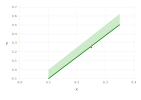

In [19]:
nextWs2 = nextWs + y * x
nextLine2 = weightsToLine(nextWs2[1], nextWs2[2:end])
nextErr2 = nextWs2' * x
span = collect(0.1:0.05:0.35)
plot(
    layer(x=[x[2]], y=[x[3]], Geom.point, Theme(default_color=colorant"red")),
    layer(nextLine2, 0.1, 0.35, Theme(default_color=colorant"green", line_width=2pt)),
    layer(x=span, ymin=nextLine2.(span), ymax=line.(span), Geom.ribbon, Theme(default_color=colorant"light green"))
)

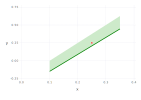

In [20]:
nextWs3 = nextWs2 + y * x
nextLine3 = weightsToLine(nextWs3[1], nextWs3[2:end])
nextErr3 = nextWs3' * x
span = collect(0.1:0.05:0.35)
plot(
    layer(x=[x[2]], y=[x[3]], Geom.point, Theme(default_color=colorant"red")),
    layer(nextLine3, 0.1, 0.35, Theme(default_color=colorant"green", line_width=2pt)),
    layer(x=span, ymin=nextLine3.(span), ymax=line.(span), Geom.ribbon, Theme(default_color=colorant"light green"))
)

![exito](https://s2-ssl.dmcdn.net/IHB9C/1280x720-GIs.jpg)

Ahora hace falta saber que esto va a suceder sin importar los parámetros ni la entrada mal clasificada que consideremos.

Partiendo de nuestro criterio de que tan mál clasificado está la entrada en una determinada iteración $t$, tenemos que el siguiente producto es un valor negativo:

$$ y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t) $$

Después de aplicar la regla de actualización, esperamos que los parámetros $\bar{w}(t+1)$ sean mejores que $\bar{w}(t)$ para la entrada $\bar{x}(t)$. Desarrollando el criterio de actualización para los parámetros actualizados, obtenemos lo siguiente:

$$
\begin{align}
y(t) \cdot \bar{w}^T(t+1) \cdot \bar{x}(t) &= y(t) \cdot [\bar{w}(t) + y(t)\cdot \bar{x}(t)]^T \cdot \bar{x}(t) & \mathrm{(1)} \\
&= y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t) + y(t) \cdot [y(t)\cdot \bar{x}(t)]^T \cdot \bar{x}(t) & \mathrm{(2)} \\
&= \left( y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)\right) + y(t) \cdot y(t) \cdot \bar{x}^T(t) \cdot \bar{x}(t) & \mathrm{(3)} \\
&= \left( y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)\right) + y(t)^2 \cdot \| \bar{x}(t) \|^2 & \mathrm{(4)} \\
&= \left( y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)\right) + \| \bar{x}(t) \|^2 & \mathrm{(5)}
\end{align}
$$

1. Se expande $\bar{w}(t+1)$ por su definición;
2. Se multiplican los dos términos de la expansión por $y(t)$ a la izquierda y $\bar{x}(t)$ a la derecha;
3. Se agrupa el término de la izquierda y se expande la multiplicación del término de la derecha;
4. Se agrupa la multiplicación de las dos $y(t)$ y se identifica a $\bar{x}^T(t) \cdot \bar{x}(t)$ como equivalente al cuadrado de la magnitud del vector de entrada;
5. Ya que $y(t)$ puede ser $+1$ o $-1$, el valor de su cuadrado es $1$, el cual no afecta la multiplicación.

---

Para verificar que el paso 4 es correcto se pueden comparar las definiciones de ambas operaciones:

$$ \bar{x}^T \cdot \bar{x} = \sum_{i=0}^{d} \bar{x}_i \cdot \bar{x}_i = \sum_{i=0}^{d} \bar{x}_i^2 $$

$$ \| \bar{x} \| = \sqrt{\left( \sum_{i=0}^{d} \bar{x}_i^2 \right)} $$

Por lo tanto

$$ \bar{x}^T \cdot \bar{x} = \| \bar{x} \|^2 $$

---

La igualdad final termina siendo:

$$ y(t) \cdot \bar{w}^T(t+1) \cdot \bar{x}(t) = \left( y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)\right) + \| \bar{x}(t) \|^2 $$

El primer término del lado derecho de la igualdad es el criterio que determina que tan mal clasifican los parámetros de la iteración anterior a la misma entrada $\bar{x}(t)$, mientras que el segundo término del lado derecho nos indica qué tanto mejoró en el paso de la iteración $t$ a la iteración $t+1$.

Para asegurar que la regla de actualización de parámetros siempre mejora, debemos demostrar que $\| \bar{x}(t) \|^2$ no puede ser negativa. Los elementos de $\bar{x}(t)$ son números reales, la magnitud de un vector real siempre es un número real y elevar al cuadrado un número real siempre resulta en un número real no negativo. Por lo tanto, esta regla siempre va a mejorar los parámetros del perceptrón para una entrada mal clasificado en específico.

Matemáticamente este resultado se puede escribir como:

$$ y(t) \cdot \bar{w}^T(t+1) \cdot \bar{x}(t) > y(t) \cdot \bar{w}^T(t) \cdot \bar{x}(t)$$

#### ¿El algoritmo termina en una cantidad finita de iteraciones?

Una manera para demostrar que el algoritmo termina en una cantidad finita de iteraciones (es decir, "converge en $t$ finita") es encontrando una cota superior a la cantidad de iteraciones del algoritmo. Con esto nos referimos a poder encontrar un número finito de pasos $t^*$ en el que podemos asegurar que llegaremos a unos parámetros $\bar{w}(t)$ que clasifiquen correctamente los datos de entrenamiento desde unos parámetros iniciales $\bar{w}(0)$, donde $t \leq t^*$.

Esta cota superior no tiene porque ser un número en concreto, de echo en general, es imposible poder calcular un número finito como cota superior para cualquier problema de clasificación binaria. Para fines de esta exploración, basta con encontrar un valor que podamos asegurar que es *finito*.

La idea principal detrás de la demostración es la siguiente:

Suponiendo que los datos son linealmente separables (existe $\bar{w}^*$), podemos encontrar una manera de calcular qué tan buenos o malos son los parámetros $\bar{w}(t)$ a comparación de $\bar{w}^*$. Esto es diferente al criterio que se abordó en la anterior parte de esta sección ya que en aquel caso la comparación era entre unos parámetros y un punto. Lo que ahora queremos explorar es una comparación entre dos parámetros.

Una manera intuitiva de pensar en como comparar dos parámetros es visualizarlos como rectas:

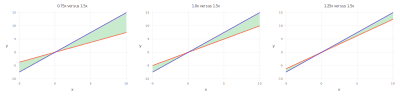

In [21]:
xs = -5:10
m = 1.50
m1 = 0.75
m2 = 1.0
m3 = 1.25

y = m * xs
y1 = m1 * xs
y2 = m2 * xs
y3 = m3 * xs

plt = (xs, ys, zs, m1, m2) -> plot(
    layer(x=xs, y=ys, Geom.line, Theme(default_color=colorant"slateblue", line_width=2pt)),
    layer(x=xs, y=zs, Geom.line, Theme(default_color=colorant"tomato", line_width=2pt)),
    layer(x=xs, ymin=ys, ymax=zs, Geom.ribbon, Theme(default_color=colorant"springgreen")),
    Guide.title("$(m2)x versus $(m1)x")
)
p1 = plt(xs, y, y1, m, m1)
p2 = plt(xs, y, y2, m, m2)
p3 = plt(xs, y, y3, m, m3)
draw(SVGJS(40cm, 10cm), hstack(p1, p2, p3))

En el ejemplo de arriba, se grafican tres rectas diferentes comparadas con $y=1.5x$ y se puede observar que entre más parecidas sean las pendientes, más parecidas son las rectas. Esto lo podemos medir de diferentes formas, pero una que es bastante útil es calculando el ángulo entre las dos rectas (el cuál relaciona conceptualmente la diferencia de pendientes).

Algo engañoso sobre las gráficas de arriba es que no estamos considerando rectas con diferente "altura", de ser así no basta con comparar pendientes. Es por esto que es conveniente trabajar directamente con los vectores de los parámetros.

Si tenemos dos vectores de parámetros $\bar{w_1}$ y $\bar{w_2}$ podemos encontrar el ángulo entre ellos utilizando la fórmula del coseno para el producto punto:

$$
\begin{align}
\bar{w_1}^{T} \cdot \bar{w_2} &= \| \bar{w_1} \| \cdot \| \bar{w_2} \| \cdot \cos{(\theta)} & \mathrm{(1)} \\
\cos{(\theta)} &= \frac{\bar{w_1}^{T} \cdot \bar{w_2}}{\| \bar{w_1} \| \cdot \| \bar{w_2} \|} & \mathrm{(2)} \\
\theta &= \arccos{\left( \frac{\bar{w_1}^{T} \cdot \bar{w_2}}{\| \bar{w_1} \| \cdot \| \bar{w_2} \|} \right)} & \mathrm{(3)}
\end{align}
$$

De esta manera, podemos demostrar que conforme se mejoran los parámetros $\bar{w}(t)$ el ángulo con respecto a $\bar{w}^*$ es cada vez menor. Sin embargo, la ecuación $(3)$ no es la más conveniente de usar en este caso. Podemos aprovechar que $\cos{(x)}$ tiene un valor máximo de $1$ para establecer la siguiente desigualdad a partir de $(2)$:

$$ 1 \geq \cos{(\theta)} = \frac{\bar{w_1}^{T} \cdot \bar{w_2}}{\| \bar{w_1} \| \cdot \| \bar{w_2} \|} $$

Al considerar los parámetros $\bar{w}(t)$ con respecto a $\bar{w}^*$ esta desigualdad es:

$$ 1 \geq \frac{\bar{w}^{*T} \cdot \bar{w}(t)}{\|\bar{w}^{*T}\| \cdot \|\bar{w}(t)\|} $$

El siguiente paso es encontrar la manera de propagar esta desigualdad hasta llegar a una fórmula que dependa de $t$. Ya que se está comparando un parámetro en un $t$ dado con parámetros perfectos, debemos analizar la manera en cómo cambia esta expresión de la derecha conforme avanzan las iteraciones. En lugar de abordar el cociente de un fregazo, primero exploramos el numerador y posteriormente el denominador.

##### El numerador

$$
\begin{align}
\bar{w}^{*T} \cdot \bar{w}(t) &= \bar{w}^{*T} \left[\bar{w}(t-1) + y(t-1) \cdot \bar{x}(t-1)\right] & \mathrm{(1)} \\
&= \bar{w}^{*T} \cdot \bar{w}(t-1) + y(t-1) \cdot \bar{w}^{*T} \cdot \bar{x}(t-1) & \mathrm{(2)} \\
&= \left[ \bar{w}^{*T} \cdot \bar{w}(t-1) \right] + \left[ y(t-1) \cdot \bar{w}^{*T} \cdot \bar{x}(t-1) \right] & \mathrm{(3)} \\
&\geq \left[ \bar{w}^{*T} \cdot \bar{w}(t-1) \right] + \gamma & \mathrm{(4)} \\
&\geq \left[ \bar{w}^{*T} \cdot \bar{w}(t-2) \right] + \gamma + \gamma & \mathrm{(5)} \\
&= \left[ \bar{w}^{*T} \cdot \bar{w}(t-2) \right] + 2\gamma & \mathrm{(6)} \\
&... & \mathrm{(7)} \\
&\geq \left[ \bar{w}^{*T} \cdot \bar{w}(t-t) \right] + t\gamma & \mathrm{(8)} \\
&= \left[ \bar{w}^{*T} \cdot \bar{w}(0) \right] + t\gamma & \mathrm{(9)} \\
&= \left[ \bar{w}^{*T} \cdot \bar{0} \right] + t\gamma & \mathrm{(10)} \\
&\geq t\gamma & \mathrm{(11)}
\end{align}
$$

Este desarrollo puede parecer bastante complejo o talachudo, sin embargo, lo que debemos tener en mente son las suposiciones y los resultados de las secciones previas:

1. Se aplica la regla de actualización de parámetros a $\bar{w}(t)$;
2. Se distribuye el producto de $\bar{w}^{*T}$ sobre la expansión de la regla de actualización;
3. Se agrupa el paso recursivo (primer término) y el remanente del cálculo (segundo término);
4. El remanente es el márgen del dato $\bar{x}(t-1)$ con los parámetros $\bar{w}^*$ por lo que podemos asegurar que será mayor al márgen $\gamma$;
5. Se realizan los mismos pasos para el paso recursivo;
6. Por cada aplicación de la regla, el valor de $\bar{w}^{*T}\cdot\bar{w}$ aumenta en al menos $\gamma$;
7. Se repite la aplicación de la regla una y otra vez;
8. El caso base es cuando $t=0$;
9. Para $t=0$ el valor de $\bar{w}$ ya se conoce (por suposición 3);
10. El término $\bar{w}^*$ se anula con el vector de ceros;
11. Obtenemos que el numerador $\bar{w}^{*T}\cdot\bar{w}(t) \geq t\gamma$.

##### El denominador

$$
\begin{align}
\|\bar{w}^*\| \cdot \|\bar{w}(t)\| &= \|\bar{w}^*\| \cdot \|\bar{w}(t-1)+y(t-1)\cdot\bar{x}(t-1)\| & \mathrm{(1)} \\
\left[\|\bar{w}^*\| \cdot \|\bar{w}(t)\|\right]^2 &= \left[\|\bar{w}^*\| \cdot \|\bar{w}(t-1)+y(t-1)\cdot\bar{x}(t-1)\|\right]^2 & \mathrm{(2)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left[\|\bar{w}(t-1)+y(t-1)\cdot\bar{x}(t-1)\|\right]^2 & \mathrm{(3)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left[\bar{w}(t-1)+y(t-1)\cdot\bar{x}(t-1)\right]^2 & \mathrm{(4)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(t-1)\right]^2 + \left[\bar{x}(t-1)\right]^2 + 2\left[y(t-1)\cdot\bar{w}^T(t-1)\cdot\bar{x}(t-1)\right] \right) & \mathrm{(5)} \\
&\leq \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(t-1)\right]^2 + \left[\bar{x}(t-1)\right]^2 \right) & \mathrm{(6)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(t-1)\right]^2 + \left[\|\bar{x}(t-1)\|\right]^2 \right) & \mathrm{(7)} \\
&\leq \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(t-1)\right]^2 + R^2 \right) & \mathrm{(8)} \\
&... & \mathrm{(9)} \\
&\leq \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(t-t)\right]^2 + tR^2 \right) & \mathrm{(10)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{w}(0)\right]^2 + tR^2 \right) & \mathrm{(11)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot \left( \left[\bar{0}\right]^2 + tR^2 \right) & \mathrm{(12)} \\
&= \left[\|\bar{w}^*\|\right]^2 \cdot tR^2 & \mathrm{(13)} \\
\|\bar{w}^*\| \cdot \|\bar{w}(t)\| &\leq \|\bar{w}^*\| \cdot \sqrt{(tR^2)} & \mathrm{(14)}
\end{align}
$$

El desarrollo del numerador es un poco más truculento que el del denominador, esto es debido a que debemos trabajar con valores absolutos y desigualdades. Sin embargo, se aplican las mismas técnicas que en el desarrollo del numerador. La única diferencia es que primero elevamos ambos términos al cuadrado (para deshacernos del valor absoluto) y al final calculamos la raíz cuadrada de ambos lados.

1. Se aplica la regla de actualización de parámetros a $\|\bar{w}(t)\|$;
2. Se eleva al cuadrado en ambos lados de la igualdad;
3. Se separa el cuadrado del término $\|\bar{w}^*\|$ (ya que este no cambia); 
4. Ignoramos el valor absoluto del segundo término $\|x\|^2 = x^2$;
5. Se desarrolla el segundo término con la ancestral técnica de "el cuadrado del primero más el cuadrado del segundo más el doble del primero por el segundo";
6. El término de la parte de "el doble del primero por el segundo" siempre será menor a cero cuando se trata de un dato mal clasificado;
7. Volvemos a introducir el valor absoluto que habíamos quitado para observar que $R$ es mayor a cualquier magnitud del conjunto de entrenamiento;
8. Denotamos la desigualdad usando a $R$;
9. Realizamos el mismo proceso de desarrollo para $\|\bar{w}(t-1)\|^2$;
10. Eventualmente llegamos al $t$-ésimo desarrollo;
11. Este no se necesita expandir ya que conocemos el valor de $\bar{w}(0)$;
12. Reemplazamos $\bar{w}(0)$ por $\bar{0}$;
13. Ya que $\bar{0} + \bar{v} = \bar{v}$ se elimina a $\bar{0}$ de la expresión;
14. Se calcula la raíz cuadrada en ambos lados de la desigualdad.

Con estos dos resultados podemos completar la desigualdad acotada por $1$ de la siguiente manera:

$$
\begin{align}
1 &\geq \frac{\bar{w}^{*T} \cdot \bar{w}(t)}{\|\bar{w}^{*T}\| \cdot \|\bar{w}(t)\|} & \\
&\geq \frac{t\gamma}{\|\bar{w}^{*T}\| \cdot \|\bar{w}(t)\|} & \mathrm{(1)} \\
&\geq \frac{t\gamma}{\|\bar{w}^*\| \cdot \sqrt{tR^2}} & \mathrm{(2)} \\
\|\bar{w}^*\| \cdot \sqrt{tR^2} &\geq t\gamma & \mathrm{(3)} \\
\bar{w}^{*2} \cdot tR^2 &\geq t^2\gamma^2 & \mathrm{(4)} \\
\bar{w}^{*2} \cdot R^2 &\geq t\gamma^2 & \mathrm{(5)} \\
\frac{\bar{w}^{*2} \cdot R^2}{\gamma^2} &\geq t & \mathrm{(6)}
\end{align}
$$

Este desarrollo consiste en aplicar los resultados del numerador $(1)$ y del denominador $(2)$. En esta parte puede resultar confusa la manera en como se aplicó el resultado del denominador (ya que la desigualdad era $\leq$), sin embargo cuando se considera que el valor en el denominador en $(1)$ es menor al valor del denominador en $(2)$, el valor de la fracción $(1)$ es mayor al de la fracción $(2)$.

Para el resto de los pasos, solo ocupamos despejar la variable $t$. Teniendo la desigualdad de $(6)$ tenemos que $t$ es menor a que una operación que resulta en un número real finito.

---

Como observación final, es importante remarcar que el valor de $t$ en el desarrollo de la demostración representa las iteraciones en donde se procesó una entrada mal clasificada. Si queremos obtener la cota para las iteraciones totales $T$ podemos considerar que siempre se actualizó una entrada en cada iteración, esto no es verdad ya que con el paso de las iteraciones cada vez menos entradas están mal clasificadas, sin embargo, para fines de dar una cota superior finita basta con considerar a $N$ como la cantidad de entradas en el conjunto de entrenamiento. De tal manera que:

$$ \frac{N\cdot \bar{w}^{*2} \cdot R^2}{\gamma^2} \geq  T $$

---